In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
#import matplotlib

import pandas as pd
import numpy as np
import durationpy
import math
from os.path import join
from collections import defaultdict


In [2]:
plt.style.use('ggplot')

COLORS_DEFAULT ={'blue': '#348ABD', 'red': '#E24A33'}

In [3]:
# conda install -c phlya adjusttext 
from adjustText import adjust_text

## csv result files directory name and file names

In [4]:
CSV_RESULT_DIR = "../wasm-engines/testresults"

WASM_RESULT_FILE = "standalone_wasm_results.csv"
NATIVE_RESULT_FILE = "native_benchmarks.csv"




## To add a new engine, add the engine name used in the csv file to this list

In [5]:
INTERPRETER_ENGINES = ['life', 'wagon', 'wasmi', 'wabt', 'v8-interpreter', 'wasm3', 'wamr']
COMPILER_ENGINES = ['lifePolymerase', 'wasmtime', 'wavm', 'v8-liftoff', 'v8-turbofan', 'asmble']

wasm_vm_names = INTERPRETER_ENGINES + COMPILER_ENGINES

## Helper funcs

In [6]:
def toMs(secs):
    if secs < 0.001:
        μs = secs * 1000000
        return "{}μs".format(round(μs, 1))
    if secs < 0.1:
        ms = secs * 1000
        return "{}ms".format(round(ms, 1))
    elif secs < 1:
        ms = secs * 1000
        return "{}ms".format(int(round(ms, 0)))
    else:
        return "{}s".format(round(secs, 2))

In [7]:
def labelBarHeights(ax, to_ms=True, small=False, to_factor=False, lower_y_bound=True):
    labels = []
    for p in ax.patches:
        if p.get_height() == 0:
            continue
        label_val = p.get_height()
        #print("height:", p.get_height())
        y_pos = p.get_y() + label_val
        #y_offset = -10
        y_offset = 0
        y_bound = ax.get_ybound()[1]
        if y_pos > y_bound:
            y_pos = y_bound
        #if label_val < (0.03 * y_bound):
            # if bar is too small to fit text, place above the bar
            #y_offset = 5
        if lower_y_bound:
            if label_val < (0.03 * y_bound) and small is False:
                # don't place labels near bottom axis, adjust_text cant deal
                y_offset = 0.03 * y_bound
        
        if label_val > 1000:
            label_val = int(label_val)
        if to_ms:
            label_val = toMs(label_val)
        if to_factor:
            if not isinstance(to_factor, int):
                to_factor = 2
            label_val = str(round(label_val, to_factor)) + "x"
        """
        txt_label = ax.annotate(toMs(label_val),
                    (p.get_x()+p.get_width()/2.,
                     y_pos),
                    ha='center',
                    va='center',
                    xytext=(0, y_offset),
                    textcoords='offset points',
                    fontsize=10,
                    weight="bold")
        """
 
        txt_label = ax.text(
                    x=p.get_x()+p.get_width()/2.,
                    y=y_pos+y_offset,
                    s=label_val,
                    ha='center',
                    va='center',
                    #xytext=(0, y_offset),
                    #textcoords='offset points',
                    fontsize=10,
                    weight="bold")

        labels.append(txt_label)

    #adjust_text(labels, ax=ax)
    return labels

In [8]:
def labelBarWidths(ax, to_ms=True, to_factor=False, to_kb=False, round_places=None):
    for p in ax.patches:
        label_val = p.get_width()
        if label_val == 0:
            continue
        #print("bar width:", label_val)
        x_pos = p.get_x() + label_val
        x_offset = -30
        x_bound = ax.get_xbound()[1]
        if (x_pos > x_bound):
            x_pos = x_bound
        #if label_val < (0.25 * x_bound):
        if label_val < (0.15 * x_bound):
            # if bar is too small to fit text, place next to bar
            x_offset = 30
        if label_val > 1000:
            label_val = int(label_val)
        if to_ms:
            label_val = toMs(label_val)
        if to_factor:
            label_val = str(round(label_val, 2)) + "x"
        if to_kb:
            kbs = label_val / 1000.0
            label_val = str(round(kbs, 1)) + " kB"
        if round_places:
            label_val = str(round(label_val, round_places))
        ax.annotate(label_val,
                    (x_pos,
                     p.get_y()+p.get_height()/2.),
                    ha='center',
                    va='center',
                    xytext=(x_offset, 0),
                    textcoords='offset points',
                    fontsize=10,
                    weight="bold")


In [9]:
def adjust_text_labels(labels, ax=None):
    adjust_text(labels, ax=ax, autoalign='y', only_move={'points':'y', 'text':'y'})
                       

In [10]:
def read_results(file_name):
    results = defaultdict(list)
    csv_results = pd.read_csv(file_name)    
    return csv_results

### Import wasm results

In [11]:
df_wasm = read_results(join(CSV_RESULT_DIR, WASM_RESULT_FILE))


In [12]:
df_wasm

,engine,test_name,elapsed_time,compile_time,exec_time
0,wagon,blake2b-2805-bytes,0.291327,0.065780,0.003218
1,wagon,blake2b-2805-bytes,0.041830,0.036019,0.003194
2,wagon,blake2b-2805-bytes,0.043238,0.037522,0.003178
3,wagon,blake2b-2805-bytes,0.042392,0.036558,0.003204
4,wagon,blake2b-2805-bytes,0.042818,0.037103,0.003186
...,...,...,...,...,...
13787,wasm3,sha1-42488-bits,0.003813,0.000012,0.001199
13788,wasm3,sha1-42488-bits,0.003657,0.000012,0.001156
13789,wasm3,sha1-42488-bits,0.003346,0.000012,0.001143
13790,wasm3,sha1-42488-bits,0.003479,0.000012,0.001174


### Import native results

In [13]:
df_native_raw = read_results(join(CSV_RESULT_DIR, NATIVE_RESULT_FILE))

In [14]:
df_native_raw

,test_name,elapsed_times,native_file_size
0,blake2b-8415-bytes,"9.4765e-05, 8.5569e-05, 0.000106563, 4.5253e-0...",980536
1,blake2b-5610-bytes,"1.0912e-05, 9.616e-06, 9.419e-06, 8.704e-06, 9...",980536
2,blake2b-2805-bytes,"5.315e-06, 5.072e-06, 5.306e-06, 6.351e-06, 5....",886064
3,bls12-381-aggreg-128-pubkeys-verify-sig,"0.085319826, 0.027020155, 0.020706156, 0.02108...",1247808
4,bls12-381-aggreg-64-pubkeys-verify-sig,"0.023118231, 0.02100854, 0.020927529, 0.022508...",1243712
5,bls12-381-aggreg-32-pubkeys-verify-sig,"0.028963954, 0.011593243, 0.010898867, 0.01078...",1243712
6,bn128_add-cdetrio11,"5.9139e-05, 4.0972e-05, 2.1109e-05, 1.6586e-05...",890136
7,bn128_add-cdetrio14,"1.0099e-05, 9.417e-06, 1.3762e-05, 9.729e-06, ...",890136
8,bn128_add-cdetrio10,"3.392e-06, 2.316e-06, 1.674e-06, 1.676e-06, 1....",890136
9,bn128_mul-cdetrio11,"0.000306138, 0.000294478, 0.000292649, 0.00048...",894280


In [15]:
native_results = {}
for i in range(len(df_native_raw)):
    test_name = df_native_raw['test_name'][i]
    native_results[test_name] = df_native_raw['elapsed_times'][i].split(', ')


In [16]:
test_names = df_native_raw['test_name'].tolist()

In [17]:
native_times = {}
for test in test_names:
    avg = np.mean([float(t) for t in native_results[test]])
    native_times[test] = avg
    


In [18]:
df_native = pd.DataFrame.from_dict(native_times, orient='index', columns=['elapsed_time'])

In [19]:
df_native

,elapsed_time
blake2b-8415-bytes,0.000025
blake2b-5610-bytes,0.000011
blake2b-2805-bytes,0.000006
bls12-381-aggreg-128-pubkeys-verify-sig,0.022314
bls12-381-aggreg-64-pubkeys-verify-sig,0.015206
bls12-381-aggreg-32-pubkeys-verify-sig,0.011469
bn128_add-cdetrio11,0.000013
bn128_add-cdetrio14,0.000004
bn128_add-cdetrio10,0.000002
bn128_mul-cdetrio11,0.000315


### sorted lists of test names for plotting inputs in order

In [20]:
blake2b_test_names = [name for name in df_wasm['test_name'].unique().tolist() if 'blake2b' in name]
blake2b_test_names.sort()
blake2b_test_names_desc = blake2b_test_names.copy()
blake2b_test_names_desc.reverse()


In [21]:
sha1_test_names = [name for name in df_wasm['test_name'].unique().tolist() if 'sha1' in name]
sha1_test_names.sort()
sha1_test_names_desc = sha1_test_names.copy()
sha1_test_names_desc.reverse()


In [22]:

bn128_mul_test_names = ['bn128_mul-cdetrio11', 'bn128_mul-chfast2', 'bn128_mul-chfast1']
bn128_add_test_names = ['bn128_add-cdetrio11', 'bn128_add-cdetrio14', 'bn128_add-cdetrio10']
bn128_pairing_test_names = ['bn128_pairing-ten_point_match_1', 'bn128_pairing-two_point_match_2', 'bn128_pairing-one_point']

bn128_mul_test_names.reverse()
bn128_add_test_names.reverse()
bn128_pairing_test_names.reverse()

bn128_mul_test_names_desc = ['bn128_mul-cdetrio11', 'bn128_mul-chfast2', 'bn128_mul-chfast1']
bn128_add_test_names_desc = ['bn128_add-cdetrio11', 'bn128_add-cdetrio14', 'bn128_add-cdetrio10']
bn128_pairing_test_names_desc = ['bn128_pairing-ten_point_match_1', 'bn128_pairing-two_point_match_2', 'bn128_pairing-one_point']



### Prepare interpreter dataframe

In [23]:
df_wasm

,engine,test_name,elapsed_time,compile_time,exec_time
0,wagon,blake2b-2805-bytes,0.291327,0.065780,0.003218
1,wagon,blake2b-2805-bytes,0.041830,0.036019,0.003194
2,wagon,blake2b-2805-bytes,0.043238,0.037522,0.003178
3,wagon,blake2b-2805-bytes,0.042392,0.036558,0.003204
4,wagon,blake2b-2805-bytes,0.042818,0.037103,0.003186
...,...,...,...,...,...
13787,wasm3,sha1-42488-bits,0.003813,0.000012,0.001199
13788,wasm3,sha1-42488-bits,0.003657,0.000012,0.001156
13789,wasm3,sha1-42488-bits,0.003346,0.000012,0.001143
13790,wasm3,sha1-42488-bits,0.003479,0.000012,0.001174


In [24]:
interp_results_for_df = []
for engine in INTERPRETER_ENGINES:
    df_engine = df_wasm[df_wasm['engine'] == engine]
    df_means = df_engine.groupby(['test_name']).mean()
    test_names = df_engine['test_name'].unique().tolist()
    for test_name in test_names:
        interp_results_for_df.append([engine, test_name] + df_means.loc[test_name].tolist())


In [25]:
interp_results_for_df

[['life',
  'blake2b-2805-bytes',
  0.017520108222961427,
  0.01188712,
  0.0023290200000000007],
 ['life',
  'blake2b-5610-bytes',
  0.020176472663879393,
  0.012722599999999999,
  0.0042794999999999995],
 ['life',
  'blake2b-8415-bytes',
  0.024049038887023925,
  0.014366859999999999,
  0.006408820000000002],
 ['life',
  'bn128_add-cdetrio10',
  0.06315744400024415,
  0.056121260000000006,
  0.00090794],
 ['life',
  'bn128_add-cdetrio11',
  0.07305096626281739,
  0.05914954,
  0.007462779999999998],
 ['life',
  'bn128_add-cdetrio14',
  0.0582549524307251,
  0.05097093999999999,
  0.0020782400000000003],
 ['life',
  'bn128_mul-cdetrio11',
  0.44757593154907227,
  0.05613823999999999,
  0.3853459399999999],
 ['life', 'bn128_mul-cdetrio12', 0.45875139713287355, 0.06970424, 0.38209186],
 ['life',
  'bn128_mul-cdetrio2',
  0.3366551923751831,
  0.04507872000000001,
  0.2870824799999999],
 ['life',
  'bn128_mul-cdetrio6',
  0.3919395685195923,
  0.04564354000000002,
  0.34160428],
 ['life'

In [26]:
df_interp = pd.DataFrame(interp_results_for_df)

In [27]:
df_interp.columns = ['engine', 'test_name', 'elapsed_time', 'parse_time', 'exec_time']

In [28]:
df_interp.set_index('engine', inplace=True)

In [29]:
df_interp['total_time'] = df_interp['parse_time'] + df_interp['exec_time']

In [30]:
df_interp

,test_name,elapsed_time,parse_time,exec_time,total_time
engine,,,,,
life,blake2b-2805-bytes,0.017520,0.011887,0.002329,0.014216
life,blake2b-5610-bytes,0.020176,0.012723,0.004279,0.017002
life,blake2b-8415-bytes,0.024049,0.014367,0.006409,0.020776
life,bn128_add-cdetrio10,0.063157,0.056121,0.000908,0.057029
life,bn128_add-cdetrio11,0.073051,0.059150,0.007463,0.066612
...,...,...,...,...,...
wamr,modexp-nagydani-1-qube,0.028389,0.000539,0.020700,0.021239
wamr,modexp-nagydani-1-square,0.028897,0.000587,0.020564,0.021152
wamr,sha1-10808-bits,0.003880,0.000540,0.000626,0.001166


## Interpreter engines compared

In [31]:
def plotInterpThreeTests(df_testdata, three_names, title="Title"):
    df_1 = df_testdata[df_testdata['test_name'] == three_names[0]]
    df_2 = df_testdata[df_testdata['test_name'] == three_names[1]]
    df_3 = df_testdata[df_testdata['test_name'] == three_names[2]]
    plt.figure()
    f, (ax1) = plt.subplots(1, 3, sharey=True, figsize=(16,7))
    df_1.sort_values('total_time')[['parse_time', 'exec_time']].plot.bar(ax=ax1[0], stacked=True)
    ax1[0].set_title(three_names[0])
    ax1[0].set(xlabel='')
    df_2.sort_values('total_time')[['parse_time', 'exec_time']].plot.bar(ax=ax1[1], stacked=True)
    ax1[1].set_title(three_names[1])
    ax1[1].set(xlabel='')
    df_3.sort_values('total_time')[['parse_time', 'exec_time']].plot.bar(ax=ax1[2], stacked=True)
    ax1[2].set_title(three_names[2])
    ax1[2].set(xlabel='')
    adjust_text_labels(labelBarHeights(ax1[0]), ax=ax1[0])
    adjust_text_labels(labelBarHeights(ax1[1]), ax=ax1[1])
    adjust_text_labels(labelBarHeights(ax1[2]), ax=ax1[2])
    ax1[0].legend(labels=["startup time", "execution time"])
    ax1[1].legend(labels=["startup time", "execution time"])
    ax1[2].legend(labels=["startup time", "execution time"])

    ax1[1].tick_params(axis='y', left=True, labelleft=True)
    ax1[2].tick_params(axis='y', left=True, labelleft=True)
    
    scale_y = 1e-3
    ticks_y = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y/scale_y))
    ax1[1].yaxis.set_major_formatter(ticks_y)
    
    ax1[0].set(ylabel='milliseconds')
    
    f.suptitle(title, fontsize=16, y=0.98)
    plt.show()

<Figure size 432x288 with 0 Axes>

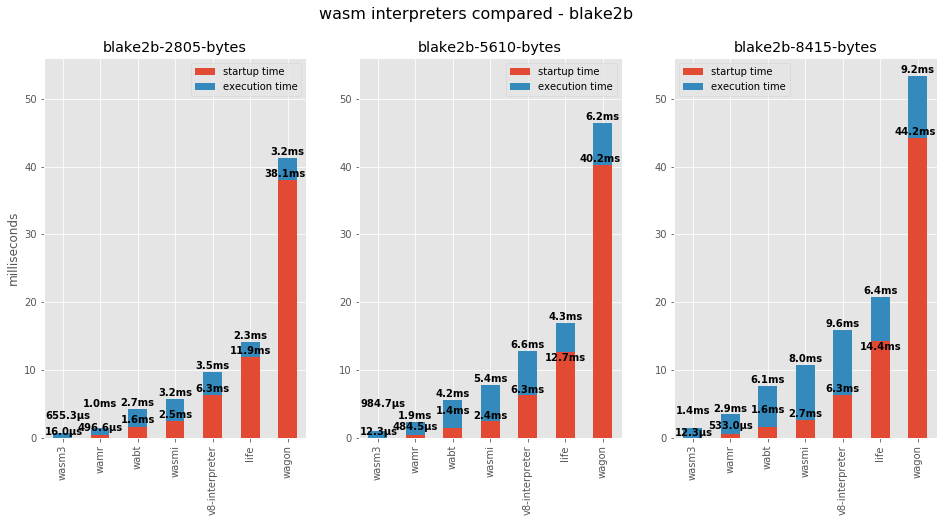

In [32]:
plotInterpThreeTests(df_interp, blake2b_test_names, title="wasm interpreters compared - blake2b")

### Interpreters - Execution time

In [33]:
def plotThreeTestsExecTime(df_testdata, three_names, title="Title"):
    df_1 = df_testdata[df_testdata['test_name'] == three_names[0]]
    df_2 = df_testdata[df_testdata['test_name'] == three_names[1]]
    df_3 = df_testdata[df_testdata['test_name'] == three_names[2]]
    plt.figure()
    f, (ax1) = plt.subplots(1, 3, sharey=True, figsize=(16,7))
    df_1.sort_values('exec_time')[['exec_time']].plot.bar(ax=ax1[0], color=COLORS_DEFAULT['blue'])
    ax1[0].set_title(three_names[0])
    ax1[0].set(xlabel='')
    df_2.sort_values('exec_time')[['exec_time']].plot.bar(ax=ax1[1], color=COLORS_DEFAULT['blue'])
    ax1[1].set_title(three_names[1])
    ax1[1].set(xlabel='')
    df_3.sort_values('exec_time')[['exec_time']].plot.bar(ax=ax1[2], color=COLORS_DEFAULT['blue'])
    ax1[2].set_title(three_names[2])
    ax1[2].set(xlabel='')
    adjust_text_labels(labelBarHeights(ax1[0]), ax=ax1[0])
    adjust_text_labels(labelBarHeights(ax1[1]), ax=ax1[1])
    adjust_text_labels(labelBarHeights(ax1[2]), ax=ax1[2])
    ax1[0].legend(labels=["execution time"])
    ax1[1].legend(labels=["execution time"])
    ax1[2].legend(labels=["execution time"])

    ax1[1].tick_params(axis='y', left=True, labelleft=True)
    ax1[2].tick_params(axis='y', left=True, labelleft=True)
   
    scale_y = 1e-3
    ticks_y = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y/scale_y))
    ax1[1].yaxis.set_major_formatter(ticks_y)
    
    ax1[0].set(ylabel='milliseconds')
    
    f.suptitle(title, fontsize=16, y=0.98)
    plt.show()


<Figure size 432x288 with 0 Axes>

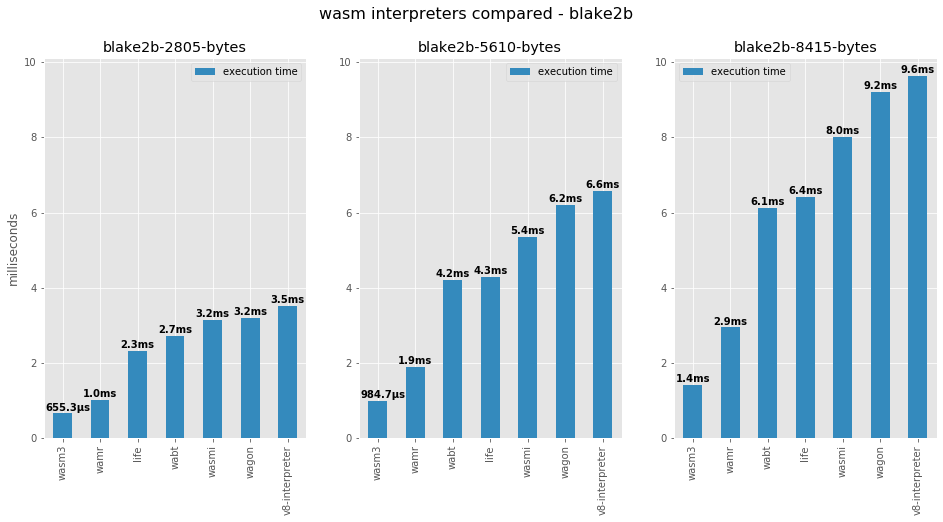

In [34]:
plotThreeTestsExecTime(df_interp, blake2b_test_names, title="wasm interpreters compared - blake2b")

## Compiler Results

In [35]:
compiler_results_for_df = []
for engine in COMPILER_ENGINES:
    df_engine = df_wasm[df_wasm['engine'] == engine]
    df_means = df_engine.groupby(['test_name']).mean()
    test_names = df_engine['test_name'].unique().tolist()
    for test_name in test_names:
        compiler_results_for_df.append([engine, test_name] + df_means.loc[test_name].tolist())

In [36]:
df_compiler = pd.DataFrame(compiler_results_for_df)

In [37]:
df_compiler

,0,1,2,3,4
0,wasmtime,blake2b-2805-bytes,0.102179,0.090814,0.000100
1,wasmtime,blake2b-5610-bytes,0.160443,0.154343,0.000124
2,wasmtime,blake2b-8415-bytes,0.289304,0.282526,0.000163
3,wasmtime,bls12-381-aggreg-128-pubkeys-verify-sig,14.238447,13.881203,0.348726
4,wasmtime,bls12-381-aggreg-32-pubkeys-verify-sig,13.882764,13.693245,0.181271
...,...,...,...,...,...
116,v8-turbofan,modexp-nagydani-1-qube,0.154063,0.064632,0.000097
117,v8-turbofan,modexp-nagydani-1-square,0.131152,0.054338,0.000094
118,v8-turbofan,sha1-10808-bits,0.088063,0.007785,0.000024
119,v8-turbofan,sha1-21896-bits,0.098089,0.010149,0.000029


In [38]:
df_compiler.columns = ['engine', 'test_name', 'elapsed_time', 'compile_time', 'exec_time']

In [39]:
df_compiler.set_index('engine', inplace=True)

In [40]:
df_compiler['total_time'] = df_compiler['compile_time'] + df_compiler['exec_time']

In [41]:
df_compiler

,test_name,elapsed_time,compile_time,exec_time,total_time
engine,,,,,
wasmtime,blake2b-2805-bytes,0.102179,0.090814,0.000100,0.090914
wasmtime,blake2b-5610-bytes,0.160443,0.154343,0.000124,0.154467
wasmtime,blake2b-8415-bytes,0.289304,0.282526,0.000163,0.282689
wasmtime,bls12-381-aggreg-128-pubkeys-verify-sig,14.238447,13.881203,0.348726,14.229929
wasmtime,bls12-381-aggreg-32-pubkeys-verify-sig,13.882764,13.693245,0.181271,13.874517
...,...,...,...,...,...
v8-turbofan,modexp-nagydani-1-qube,0.154063,0.064632,0.000097,0.064729
v8-turbofan,modexp-nagydani-1-square,0.131152,0.054338,0.000094,0.054432
v8-turbofan,sha1-10808-bits,0.088063,0.007785,0.000024,0.007808


## Delete this part

In [42]:
compiler_results_for_df

[['wasmtime',
  'blake2b-2805-bytes',
  0.10217872619628907,
  0.09081402000000001,
  0.00010013999999999999],
 ['wasmtime',
  'blake2b-5610-bytes',
  0.16044259071350098,
  0.15434300000000006,
  0.00012402000000000002],
 ['wasmtime',
  'blake2b-8415-bytes',
  0.28930365562438964,
  0.2825261600000001,
  0.00016316],
 ['wasmtime',
  'bls12-381-aggreg-128-pubkeys-verify-sig',
  14.238446533679962,
  13.881203,
  0.348726],
 ['wasmtime',
  'bls12-381-aggreg-32-pubkeys-verify-sig',
  13.882764041423798,
  13.69324525,
  0.18127125000000002],
 ['wasmtime',
  'bls12-381-aggreg-64-pubkeys-verify-sig',
  18.15734060605367,
  17.854069,
  0.2913553333333333],
 ['wasmtime',
  'bn128_add-cdetrio10',
  0.5078553819656372,
  0.50068438,
  0.00011412],
 ['wasmtime',
  'bn128_add-cdetrio11',
  0.5661757850646972,
  0.557506,
  0.00022465999999999995],
 ['wasmtime',
  'bn128_add-cdetrio14',
  0.5721772241592408,
  0.56356998,
  0.0001814400000000001],
 ['wasmtime',
  'bn128_mul-cdetrio11',
  0.90720

In [43]:
liftoff_results = []
for cr in compiler_results_for_df:
    if cr[0] == 'v8-liftoff':
        liftoff_results.append(cr)

In [44]:
liftoff_results

[['v8-liftoff',
  'blake2b-2805-bytes',
  0.0966344165802002,
  0.005787999999999998,
  4.284e-05],
 ['v8-liftoff',
  'blake2b-5610-bytes',
  0.07609227657318116,
  0.005665820000000001,
  6.777999999999999e-05],
 ['v8-liftoff',
  'blake2b-8415-bytes',
  0.07455271244049072,
  0.005529219999999997,
  9.404000000000001e-05],
 ['v8-liftoff',
  'bls12-381-aggreg-128-pubkeys-verify-sig',
  0.5156036424636841,
  0.012731299999999996,
  0.43221332],
 ['v8-liftoff',
  'bls12-381-aggreg-32-pubkeys-verify-sig',
  0.298262677192688,
  0.01308124,
  0.21295464000000003],
 ['v8-liftoff',
  'bls12-381-aggreg-64-pubkeys-verify-sig',
  0.4327088832855225,
  0.01655046,
  0.32803956000000006],
 ['v8-liftoff',
  'bn128_add-cdetrio10',
  0.09157047748565673,
  0.004695640000000001,
  3.7999999999999995e-05],
 ['v8-liftoff',
  'bn128_add-cdetrio11',
  0.10702118873596192,
  0.005602079999999999,
  0.00015153999999999995],
 ['v8-liftoff',
  'bn128_add-cdetrio14',
  0.09881353855133057,
  0.005277819999999

## Compiler function

*Note: Fix scale for v8-turbofan execution time*

In [45]:
def plotCompilerStackedOneTest(df_benchdata, test_name):
    df_1 = df_benchdata[df_benchdata['test_name'] == test_name]
    # for some reason, exec_time needs to come first for the stacked chart to display correctly
    ax = df_1[['exec_time', 'compile_time']].sort_values('exec_time').plot.bar(stacked=True, color=['#348ABD', '#E24A33'], figsize=(10,10))
    ax.set_title("Compilers - {}".format(test_name))
    ax.set_yscale("log") 
    plt.ylabel("seconds (log scale)")
    adjust_text_labels(labelBarHeights(ax, lower_y_bound=False))
    ax.legend(labels=["execution time", "compile time"])
    plt.savefig("../images/wasm-compilers.png")



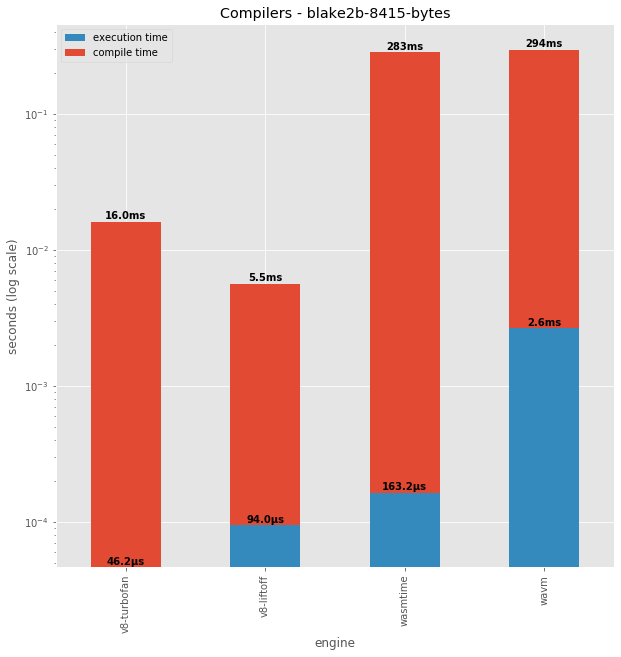

In [46]:
plotCompilerStackedOneTest(df_compiler, blake2b_test_names[2])